In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from matplotlib import gridspec


In [2]:
df = pd.read_csv("./../../data/cluster.csv", skipinitialspace=True, sep=',')
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183165 entries, 0 to 183164
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       183165 non-null  object 
 1   state                      183165 non-null  object 
 2   city_or_county             183165 non-null  object 
 3   address                    170255 non-null  object 
 4   latitude                   183165 non-null  float64
 5   longitude                  183165 non-null  float64
 6   congressional_district     179893 non-null  float64
 7   state_house_district       159656 non-null  float64
 8   state_senate_district      165004 non-null  float64
 9   participant_age1           140211 non-null  float64
 10  participant_age_group1     166554 non-null  object 
 11  participant_gender1        172022 non-null  object 
 12  min_age_participants       140224 non-null  float64
 13  avg_age_participants       14

In [3]:
# Drop rows with n_participants = 0
df.loc[df['n_participants'] == 0] = np.nan
df = df.dropna(subset=['n_participants'])
df = df[df['state']=='Illinois']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11888 entries, 16 to 183143
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       11888 non-null  object 
 1   state                      11888 non-null  object 
 2   city_or_county             11888 non-null  object 
 3   address                    11553 non-null  object 
 4   latitude                   11888 non-null  float64
 5   longitude                  11888 non-null  float64
 6   congressional_district     11748 non-null  float64
 7   state_house_district       11747 non-null  float64
 8   state_senate_district      11748 non-null  float64
 9   participant_age1           10583 non-null  float64
 10  participant_age_group1     11132 non-null  object 
 11  participant_gender1        11508 non-null  object 
 12  min_age_participants       10591 non-null  float64
 13  avg_age_participants       10591 non-null  float6

In [5]:
df['killed_ratio'] = df['n_killed']/df['n_participants'] 
df['injured_ratio'] = df['n_injured']/df['n_participants'] 
df['child_ratio'] = df['n_participants_child']/df['n_participants'] 
df['teen_ratio'] = df['n_participants_teen']/df['n_participants'] 
df['adult_ratio'] = df['n_participants_adult']/df['n_participants'] 
df['arrested_ratio'] = df['n_arrested']/df['n_participants'] 
df['unharmed_ratio'] = df['n_unharmed']/df['n_participants'] 
df['males_ratio'] = df['n_males']/df['n_participants'] 
df['females_ratio'] = df['n_females']/df['n_participants'] 

In [6]:
cols = ['latitude', 'longitude', 'congressional_district', 'state_house_district', 'state_senate_district', 'participant_age1', 'min_age_participants', 'avg_age_participants',
        'max_age_participants', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
        'n_unharmed', 'n_participants', 'povertyPercentage', 'candidatevotes', 'totalvotes', 'killed_ratio', 'injured_ratio', 'child_ratio', 'teen_ratio', 'adult_ratio', 
        'arrested_ratio', 'unharmed_ratio', 'males_ratio', 'females_ratio']
df = df[cols]
df = df.dropna()

In [7]:
corr_threshold = 0.9
print("Attributo A\t\tAttributo B\t\tCorr(A,B)")
for i in range(0, len(df.columns)):
    for j in range(i+1, len(df.columns)):
        corr = df[df.columns[i]].corr(df[df.columns[j]])
        if  corr > corr_threshold:
            print(df.columns[i] + "\t" + df.columns[j] + "\t" + '{:.3f}'.format(corr))

Attributo A		Attributo B		Corr(A,B)
state_house_district	state_senate_district	0.998
participant_age1	avg_age_participants	0.954
participant_age1	max_age_participants	0.938
min_age_participants	avg_age_participants	0.959
avg_age_participants	max_age_participants	0.957


In [8]:
cols = ['participant_age1', 'min_age_participants', 'avg_age_participants', 'max_age_participants', 'state_house_district', 'state_senate_district','candidatevotes', 'totalvotes']
df.drop(cols, axis=1, inplace=True)

## OPTICS

In [9]:
# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Normalizing the data so that the data
# approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)

# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

# Renaming the columns
X_normalized.columns = df.columns

X_normalized.head()

,latitude,longitude,congressional_district,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females,n_killed,n_injured,...,povertyPercentage,killed_ratio,injured_ratio,child_ratio,teen_ratio,adult_ratio,arrested_ratio,unharmed_ratio,males_ratio,females_ratio
0,0.092620,0.074004,0.028490,-0.018924,0.412913,0.176782,0.461778,-0.083731,0.386102,0.363542,...,-0.106799,0.123334,0.020593,-0.017637,0.159936,-0.153801,-0.088733,-0.091432,0.082083,-0.082083
1,0.044397,0.085591,-0.216502,-0.015982,0.348715,-0.283185,-0.077551,-0.070713,-0.091187,0.041448,...,0.220345,-0.088409,0.158632,-0.014895,0.551877,-0.539935,-0.074937,-0.077216,0.069321,-0.069321
2,0.025147,0.045990,-0.137260,-0.016093,-0.071636,0.368073,0.392687,-0.071203,-0.091819,0.041736,...,0.221873,-0.089021,-0.124709,-0.014998,-0.073842,0.075655,-0.075456,0.413792,0.069802,-0.069802
3,0.200799,0.197540,0.064868,-0.043088,-0.191802,-0.180482,-0.209079,-0.190643,-0.245842,0.111746,...,-0.243166,-0.238351,0.427676,-0.040157,-0.197709,0.202562,-0.202031,-0.208176,0.186892,-0.186892
4,0.108352,0.094954,0.032108,-0.021328,-0.094938,-0.089335,-0.103490,-0.094364,0.435135,-0.299086,...,-0.120362,0.652946,-0.353757,-0.019877,-0.097862,0.100264,-0.100001,-0.103043,0.092507,-0.092507


In [10]:
X_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5459 entries, 0 to 5458
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   latitude                5459 non-null   float64
 1   longitude               5459 non-null   float64
 2   congressional_district  5459 non-null   float64
 3   n_participants_child    5459 non-null   float64
 4   n_participants_teen     5459 non-null   float64
 5   n_participants_adult    5459 non-null   float64
 6   n_males                 5459 non-null   float64
 7   n_females               5459 non-null   float64
 8   n_killed                5459 non-null   float64
 9   n_injured               5459 non-null   float64
 10  n_arrested              5459 non-null   float64
 11  n_unharmed              5459 non-null   float64
 12  n_participants          5459 non-null   float64
 13  povertyPercentage       5459 non-null   float64
 14  killed_ratio            5459 non-null   

In [11]:
# Building the OPTICS Clustering model
optics_model = OPTICS(min_samples = 15, xi = 0.003, min_cluster_size = 0.05)

In [12]:
# Training the model
optics_model.fit(X_normalized)

OPTICS(min_cluster_size=0.05, min_samples=15, xi=0.003)

In [13]:
# Producing the labels according to the DBSCAN technique with eps = 0.5
labels1 = cluster_optics_dbscan(reachability = optics_model.reachability_,
core_distances = optics_model.core_distances_,
ordering = optics_model.ordering_, eps = 0.5)

# Producing the labels according to the DBSCAN technique with eps = 2.0
labels2 = cluster_optics_dbscan(reachability = optics_model.reachability_,
core_distances = optics_model.core_distances_,
ordering = optics_model.ordering_, eps = 2)

# Creating a numpy array with numbers at equal spaces till
# the specified range
space = np.arange(len(X_normalized))

# Storing the reachability distance of each point
reachability = optics_model.reachability_[optics_model.ordering_]

# Storing the cluster labels of each point
labels = optics_model.labels_[optics_model.ordering_]

print(labels)

[-1 -1 -1 ... -1 -1 -1]


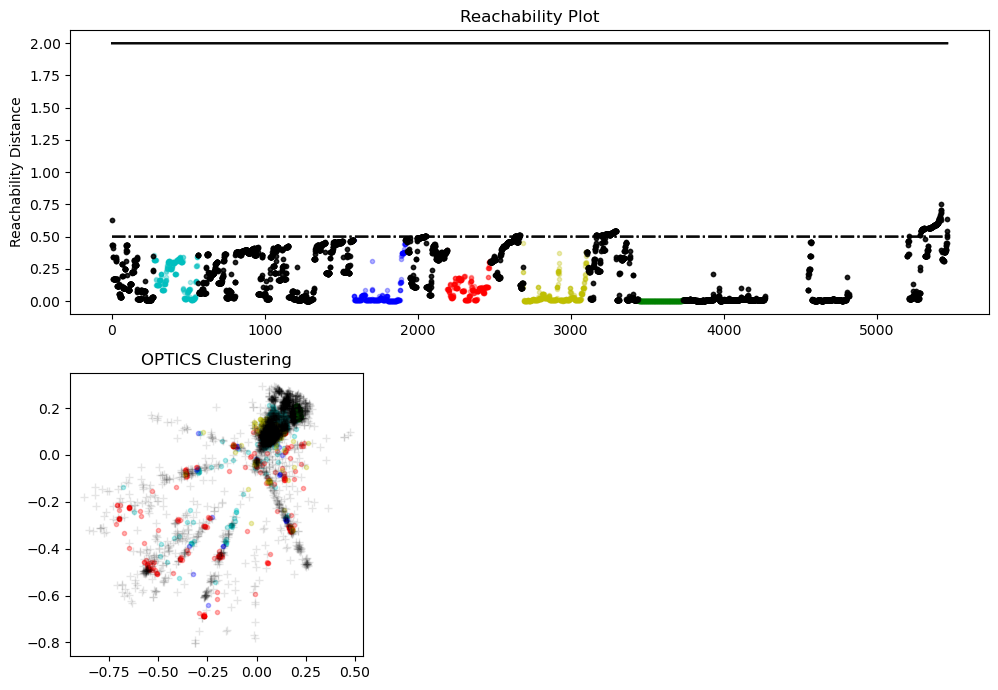

In [14]:
# Defining the framework of the visualization
plt.figure(figsize =(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])

# Plotting the Reachability-Distance Plot
colors = ['c.', 'b.', 'r.', 'y.', 'g.']
for Class, colour in zip(range(0, 5), colors):
    Xk = space[labels == Class]
    Rk = reachability[labels == Class]
    ax1.plot(Xk, Rk, colour, alpha = 0.3)
    ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha = 0.3)
    ax1.plot(space, np.full_like(space, 2., dtype = float), 'k-', alpha = 0.5)
    ax1.plot(space, np.full_like(space, 0.5, dtype = float), 'k-.', alpha = 0.5)
    ax1.set_ylabel('Reachability Distance')
    ax1.set_title('Reachability Plot')

# Plotting the OPTICS Clustering
colors = ['c.', 'b.', 'r.', 'y.', 'g.']
for Class, colour in zip(range(0, 5), colors):
    Xk = X_normalized[optics_model.labels_ == Class]
    ax2.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3)

ax2.plot(X_normalized.iloc[optics_model.labels_ == -1, 0],
X_normalized.iloc[optics_model.labels_ == -1, 1], 'k+', alpha = 0.1)
ax2.set_title('OPTICS Clustering')

plt.tight_layout()
plt.show()